# TensorFlow Core API

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
# from plotnine import *

# Quick hack to make tb highlighting configurable - https://github.com/ipython/ipython/pull/13756
# from IPython.core.ultratb import VerboseTB
# VerboseTB._tb_highlight = "bg:#039dfc"

try:
    plt.style.use("my_dracula")
except:
    plt.style.use("default")
matplotlib.rcParams['figure.figsize'] = [9, 3]

print("TensorFlow Version " + tf.__version__)
print(str(tf.config.list_physical_devices()))

TensorFlow Version 2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Naive implementation to understand and play around with the Core API

## Functions

When using Keras it's basically the same, just do these minor changes:
- swap the base class *tf.Module* with *tf.keras.layers.Layer*
- change *\_\_call\_\_* to *call* (there is no change in how it is used)
- have an extra step: *build(self, input_shape)* which is called only once, on the first call, with the input shape (usually used to initialize weights)
- should add *training* argument to *call*

Keras layers also have additional features for losses, metrics, etc.


Models in Keras can be defined as nested layers or with the class *tf.keras.Model*, which inherits from *tf.keras.layers.Layer* and has some extra functionalities specific for models. Its basic syntax is the same.


---
**Note from guide**


For historical compatibility reasons Keras layers do not collect variables from modules, so your models should **<u>use only modules or only Keras layers</u>**. However, the methods shown are the same in either case.

---

### Class declarations for NN

In [2]:
# input x must be a tensor or alike with rank 1 (single entry) or 2 (batch)
# define a dense layer
class Dense_core(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)

        # parameter initialization with He initialization for ReLu
        self.w = tf.Variable(tf.random.normal([in_features, out_features], stddev=np.sqrt(2/in_features)), name="w")
        self.b = tf.Variable(tf.zeros([self.out_features], stddev=np.sqrt(2/in_features)), name="b")

    def __call__(self, x):
        z = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(z)


# sequential layers
class Sequiential_dense_core(tf.Module):
    # layers: list of neurons per layer
    def __init__(self, in_features, layers=[1], name=None):
        super().__init__(name=name)

        self.layer = []
        for i, neurons in enumerate(layers):
            if i == 0:
                self.layer.append(Dense_core(in_features, layers[i]))
            else:
                self.layer.append(Dense_core(layers[i-1], layers[i]))

    def __call__(self, x):
        for i, _ in enumerate(self.layer):
            x = self.layer[i](x)
        return x

In [3]:
# used for shallow network with no hidden layers - only output layer
# used for my auto-bulid of DNN
class identity_layer_core(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)

    def __call__(self, x):
        return x

In [4]:
# dense layer with flexible input shape
class Flex_dense_core(tf.Module):
    def __init__(self, out_features, name=None):
        super().__init__(name=name)

        self.is_built = False
        self.out_features = out_features

    def __call__(self, x):
        # parameter initialization with He initialization for ReLu
        if not self.is_built:
            self.w = tf.Variable(tf.random.normal([x.shape[-1], self.out_features],
                                                  stddev=np.sqrt(2/x.shape[-1])), name="w")
            self.b = tf.Variable(tf.random.normal([self.out_features], stddev=np.sqrt(2/x.shape[-1])), name="b")
            self.is_built = True

        z = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(z)

In [5]:
# sequential layers
class Sequiential_flex_dense_core(tf.Module):
    # layers: list of neurons per layer
    def __init__(self, layers=[1], name=None):
        super().__init__(name=name)

        self.layer = []
        for i, neurons in enumerate(layers):
            self.layer.append(Flex_dense_core(layers[i]))

    def __call__(self, x):
        for i, _ in enumerate(self.layer):
            x = self.layer[i](x)
        return x

In [6]:
# linear output NN
class Regression_NN_core(tf.Module):
    def __init__(self, hidden_layers=[1], out_features=1, input_features=None, name=None):
        super().__init__(name=name)

        # initialize weights of linear output layer (same initialization as for ReLu layers)
        if hidden_layers[0] == 0:
            last_hidden = input_features  # for zero hidden layers case (only output layer)
            self.hidden_layers = identity_layer_core()
        else:
            last_hidden = hidden_layers[-1]
            self.hidden_layers = Sequiential_flex_dense_core(layers=hidden_layers)

        self.w = tf.Variable(tf.random.normal([last_hidden, out_features], stddev=np.sqrt(2/last_hidden)), name="w")
        self.b = tf.Variable(tf.random.normal([out_features], stddev=np.sqrt(2/last_hidden)), name="b")

    def __call__(self, x):
        # matmul requires tensors of rank >= 2
        # have to reshape x (vector, i.e. rank 1) to make sure it is a row vector in matrix form, i.e. rank 2
        if tf.rank(x) < 2:
            x = tf.reshape(x, [-1, 1])
        x = self.hidden_layers(x)
        return tf.matmul(x, self.w) + self.b

In [7]:
# MLP classifier
class Classifier_NN_core(tf.Module):
    def __init__(self, hidden_layers=[1], classes=2, input_features=None, name=None):
        super().__init__(name=name)
        if classes == 1:
            print("classes set to 2, i.e. one output feature")
            classes = 2
        if classes == 2:
            self.out_features = 1
            self.output_activation = tf.nn.sigmoid
        else:
            self.out_features = classes
            self.output_activation = tf.nn.softmax

        if hidden_layers[0] == 0:
            self.n_hidden_layers = 0
            self.hidden_layers = identity_layer_core()
        else:
            self.n_hidden_layers = len(hidden_layers)
            self.hidden_layers = Sequiential_flex_dense_core(layers=hidden_layers)

        self.built = False

    def __call__(self, x):
        # initialize weights of sigmoid output layer (normalized Xavier)
        if not self.built:
            if self.n_hidden_layers > 0:
                last_hidden = self.hidden_layers.submodules[-1].out_features
            else:    # case of no hidden layers
                last_hidden = x.shape[-1]

            xavier = np.sqrt(6)/np.sqrt(last_hidden + self.out_features)
            self.w = tf.Variable(tf.random.uniform([last_hidden, self.out_features],
                                                   minval=-xavier, maxval=xavier), name="w")
            self.b = tf.Variable(tf.random.uniform([self.out_features], minval=-xavier, maxval=xavier), name="b")
            self.built = True

        # matmul requires tensors of rank >= 2
        # have to reshape x (vector, i.e. rank 1) to make sure it is a row vector in matrix form, i.e. rank 2
        if tf.rank(x) < 2:
            x = tf.reshape(x, [-1, 1])
        x = self.hidden_layers(x)
        z = tf.matmul(x, self.w) + self.b
        return self.output_activation(z)

### Training functions

In [8]:
# define training function
# args used to pass n_classes to cross entropy loss for classification
@tf.function
def train_core(model, x, y, loss, learning_rate, *args):

    with tf.GradientTape() as t:
        current_loss = loss(y, model(x), *args)

    grad = t.gradient(current_loss, model.variables)

    for g, var in zip(grad, model.variables):
        var.assign_sub(learning_rate * g)

In [9]:
# training loop
# args used to pass n_classes to cross entropy loss for classification
def training_loop_core(model, x, y, loss, learning_rate=0.01, epochs=10, *args):
    if not tf.is_tensor(y):
        y = tf.convert_to_tensor(y)
    epochs = range(epochs+1)
    hist_loss = []
    hist_loss.append(loss(y, model(x), *args).numpy())

    for epoch in epochs[:-1]:
        train_core(model, x, y, loss, learning_rate, *args)
        hist_loss.append(loss(y, model(x), *args).numpy())

    plt.plot(epochs, hist_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training")
    # plt.show()

## Examples

### Regression

In [10]:
def MSE(y, y_pred):
    if not tf.is_tensor(y):
        y = tf.convert_to_tensor(y)
    y_pred = tf.reshape(y_pred, y.shape.as_list())
    return tf.reduce_mean(tf.square(y - y_pred))

#### Linear 1D regression

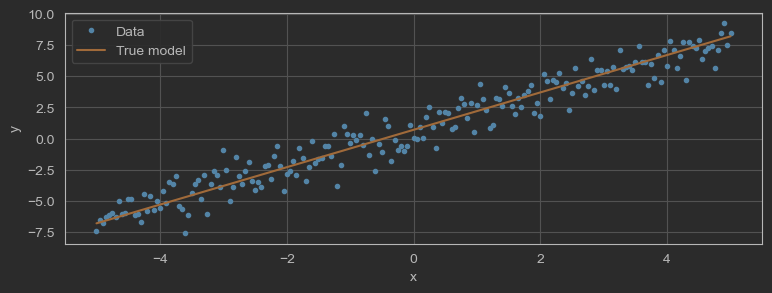

In [11]:
# Create a dataset
true_w = 1.5
true_b = .7


def f(x):
    return x * true_w + true_b


def plot_model(x, y, model=None, title="Model"):
    plt.plot(x, y, ".", label="Data")
    plt.plot(x, f(x), label="True model")
    plt.xlabel("x")
    plt.ylabel("y")
    if model is not None:
        plt.plot(x, model(x), label=title)
    plt.legend()
    # plt.show()


n = 201

x = tf.linspace(-5., 5., n)
y = f(x) + tf.random.normal([n])

plot_model(x, y)

In [12]:
model = Regression_NN_core([0], 1, 1)
model.variables

(<tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([-2.984168], dtype=float32)>,
 <tf.Variable 'w:0' shape=(1, 1) dtype=float32, numpy=array([[-2.284353]], dtype=float32)>)

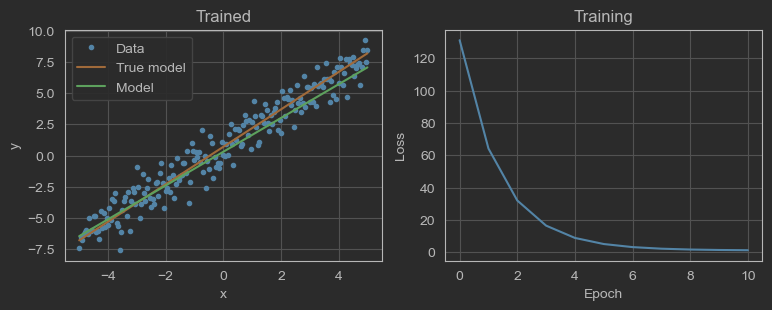

In [13]:
plt.subplot(122)
training_loop_core(model, x, y, MSE, 1e-1)
plt.subplot(121)
plot_model(x, y, model)
plt.title("Trained")
plt.show()

#### Linear 2D->1D regression

In [14]:
def plot_model_3d(coords, pred=None):
    ax = plt.gca()
    if ax.name != "3d":
        ax.remove()
        fig = plt.gcf()
        ax = fig.add_subplot(projection="3d")
    ax.scatter(coords.x, coords.y, coords.z, color="Red", label="Data", alpha=1, s=3)
    ax.plot_surface(x, y, f(x, y), alpha=.3, color="Yellow")

    if pred is not None:
        ax.scatter(coords.x, coords.y, pred, color="Blue", label="Prediction", alpha=1, s=3)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.legend()

Loss True Model: 0.00 - Loss Learned Model: 1.71


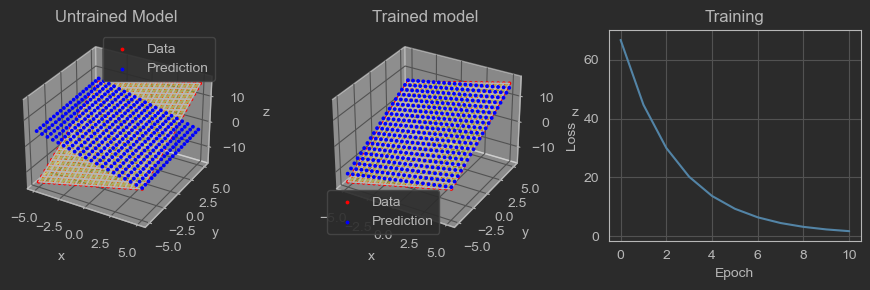

In [15]:
# create dataset
TRUE_A = 1.
TRUE_B = 2.
TRUE_C = .5

def f(x, y):
    return TRUE_A * x + TRUE_B * y + TRUE_C


N = 20

x = np.linspace(-5., 5., N, dtype=np.float32)
x, y = np.meshgrid(x, x)
coords = pd.DataFrame(np.array((x.ravel(), y.ravel())).T, columns=["x", "y"])
coords["z"] = f(coords.x, coords.y)
inputs = coords.iloc[:, :2]

model = Regression_NN_core([0], input_features=2)

plt.subplot(131, projection="3d")
plot_model_3d(coords, model(inputs))
plt.title("Untrained Model")
plt.subplot(133)
training_loop_core(model, inputs, np.array(coords.z), MSE, 1e-2)
# plt.yscale("log")
plt.subplot(132, projection="3d")
plot_model_3d(coords, model(inputs))
plt.title("Trained model")
plt.tight_layout()
print(f"Loss True Model: {MSE(coords.z, f(coords.x, coords.y)):.2f} - Loss Learned Model: {MSE(coords.z, model(inputs)):.2f}")

In [16]:
N = 20

x = np.linspace(-5., 5., N, dtype=np.float32)
x, y = np.meshgrid(x, x)
coords = pd.DataFrame(np.array((x.ravel(), y.ravel())).T, columns=["x", "y"])


def quick_test(coords, layers, f, epochs=10, lr=1e-2):
    coords["z"] = f(coords.x, coords.y)
    inputs = coords.iloc[:, :2]
    model = Regression_NN_core(layers, input_features=2)

    plt.subplot(131, projection="3d")
    plot_model_3d(coords, model(inputs))
    plt.title("Untrained Model")

    plt.subplot(133)
    training_loop_core(model, inputs, np.array(coords.z), MSE, lr, epochs)
    plt.subplot(132, projection="3d")
    plot_model_3d(coords, model(inputs))
    plt.title("Trained model")
    plt.tight_layout()

    return model

Loss True Model: 0.00 - Loss Learned Model: 7.92


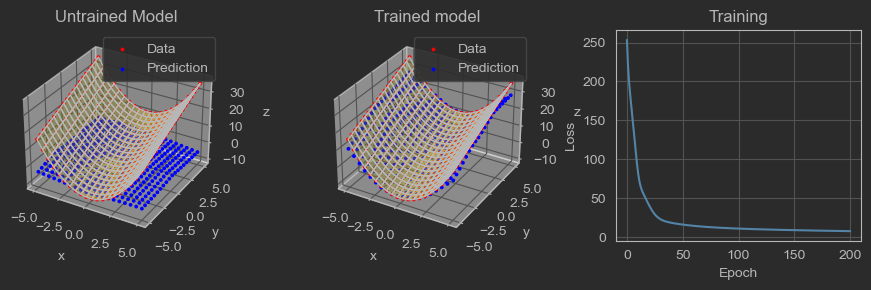

In [17]:
test_layers = [5, 5, 5]
epochs = 200
lr = 1e-3

TRUE_A = 1.
TRUE_B = 2.
TRUE_C = .5


def f(x, y):
    return TRUE_A * x**2 + TRUE_B * y + TRUE_C


model = quick_test(coords, test_layers, f, epochs, lr)
print(f"Loss True Model: {MSE(coords.z, f(coords.x, coords.y)):.2f} - Loss Learned Model: {MSE(coords.z, model(inputs)):.2f}")

### Classification

In [18]:
def cross_entropy(y, y_pred, n_classes):
    if n_classes == 2:  # case for binary classifier
        y = tf.reshape(y, [-1, 1])
        y = tf.cast(y, tf.float32)
        y_pred = tf.reshape(y_pred, y.shape.as_list())
        return - tf.reduce_mean(y * tf.math.log(y_pred) + (1. - y) * tf.math.log(1. - y_pred))
    else:  # multiclass case
        y = tf.one_hot(y, n_classes, axis=-1)
        return - tf.reduce_mean(y * tf.math.log(y_pred))

#### Linear binary example

In [19]:
def f(x):
    a = 1.
    b = 0.
    return x * a - b


def plot_2d_classes(data, labels):
    if tf.rank(labels) > 1:
        labels = tf.reshape(labels, [-1])
    p = "PRGn"
    x1 = data.columns[0]
    x2 = data.columns[1]
    sns.scatterplot(data, x=x1, y=x2, hue=labels, s=10, palette=p, legend=False, hue_norm=(0, 1))
    plt.gcf().colorbar(plt.cm.ScalarMappable(cmap=p), location="bottom", ticks=[0, 1], ax=plt.gca(),
                       pad=0.18, extend="neither", label="label", shrink=0.8)
    plt.gca().set_box_aspect(1)

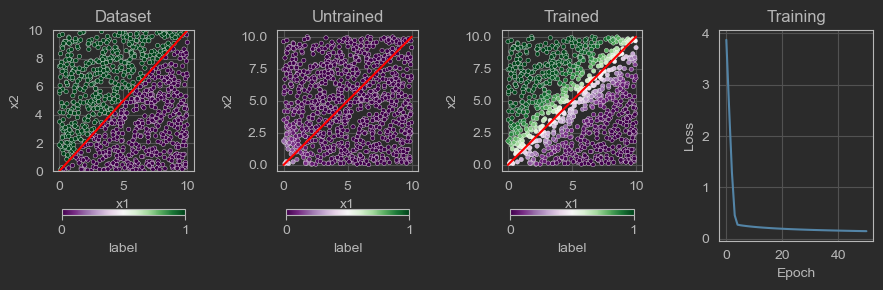

In [20]:
N = 1000
dim = 2
data = pd.DataFrame(np.random.uniform(0., 10, [N, dim]).astype(np.float32), columns=["x1", "x2"])
labels = np.where(f(data.x1) <= data.x2, 1, 0)

n_classes = 2
model = Classifier_NN_core([0], n_classes)

plt.subplot(141)
lin_space = np.linspace(0., 10.)
plt.plot(lin_space, f(lin_space), color="red")
plt.ylim(0, 10)
plot_2d_classes(data, labels)
plt.title("Dataset")

plt.subplot(142)
pred = model(data)
plot_2d_classes(data, pred)
plt.title("Untrained")
plt.plot(lin_space, f(lin_space), color="red")

plt.subplot(144)
training_loop_core(model, data, labels, cross_entropy, 1e-1, 50, n_classes)
plt.title("Training")

plt.subplot(143)
pred_trained = model(data)
plot_2d_classes(data, pred_trained)
plt.title("Trained")
plt.plot(lin_space, f(lin_space), color="red")

plt.tight_layout()
plt.show()

#### Non-linear binary example

In [21]:
N = 1000
dim = 2
R = 1.
data = pd.DataFrame(np.random.uniform(-R, R, [N, dim]).astype(np.float32), columns=["x1", "x2"])
labels = np.where(data.x1**2 + data.x2**2 <= (R/1.3)**2, 1, 0)

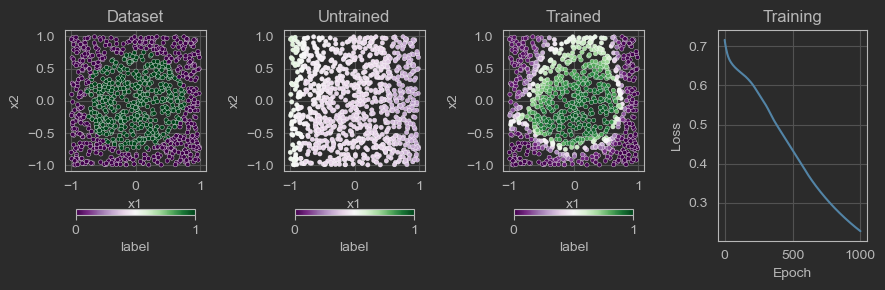

In [24]:
n_classes = 2
model = Classifier_NN_core([10, 10, 10, 10, 10], n_classes)

plt.subplot(141)
plot_2d_classes(data, labels)
plt.title("Dataset")

plt.subplot(142)
pred = model(data)
plot_2d_classes(data, pred)
plt.title("Untrained")

plt.subplot(144)
plt.title("Training")
training_loop_core(model, data, labels, cross_entropy, 1e-2, 1000, n_classes)

plt.subplot(143)
plt.title("Trained")
pred_trained = model(data)
plot_2d_classes(data, pred_trained)

plt.tight_layout()
plt.show()

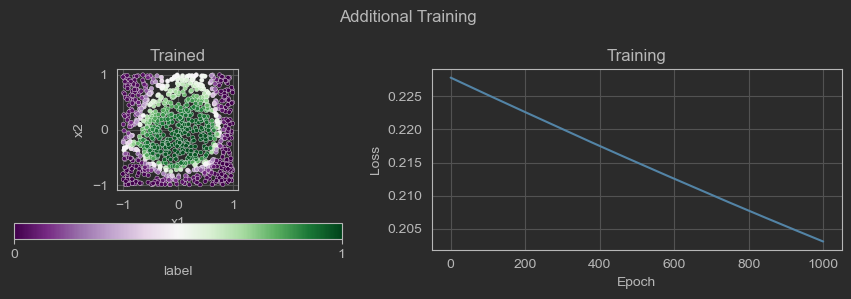

In [25]:
plt.suptitle("Additional Training")
plt.subplot(122)
training_loop_core(model, data, labels, cross_entropy, 1e-3, 1000, n_classes)

plt.subplot(121)
plt.title("Trained")
pred_trained = model(data)
plot_2d_classes(data, pred_trained)

plt.tight_layout()
plt.show()

#### Linear multi-class example

In [26]:
def plot_2d_multi_class(data, pred):
    if tf.rank(pred) == 1:
        labels = pred
        labels_p = np.ones(pred.shape)
    else:
        labels = np.argmax(pred, axis=1)
        labels_p = np.max(pred, axis=1)

    #p = "PRGn"
    x1 = data.columns[0]
    x2 = data.columns[1]
    sns.scatterplot(data, x=x1, y=x2, hue=labels, s=10, alpha=labels_p) # , palette=p, legend=False, hue_norm=(0, 1))
    # plt.gcf().colorbar(plt.cm.ScalarMappable(cmap=p), location="bottom", ticks=[0, 1], ax=plt.gca(),
    #                    pad=0.18, extend="neither", label="label", shrink=0.8)
    plt.gca().set_box_aspect(1)

In [27]:
N = 1000
dim = 2
R = 1.
data = pd.DataFrame(np.random.uniform(-R, R, [N, dim]).astype(np.float32), columns=["x1", "x2"])
data = data.assign(labels=lambda x: np.where((x.x1 < x.x2) & (-x.x1 < x.x2), 1, 0))
data = data.assign(labels=lambda x: np.where((x.x1 < x.x2) & (-x.x1 > x.x2), 2, x.labels))
data = data.assign(labels=lambda x: np.where((x.x1 > x.x2) & (-x.x1 > x.x2), 3, x.labels))
labels = data.pop("labels").astype("int")

In [28]:
n_classes = 4
model = Classifier_NN_core([4, 4], n_classes)

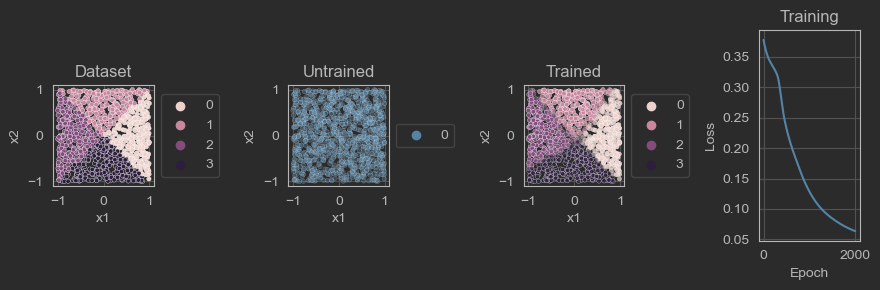

In [29]:
plt.subplot(141)
plot_2d_multi_class(data, labels)
plt.title("Dataset")
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(142)
pred = model(data)
plot_2d_multi_class(data, pred)
plt.title("Untrained")
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(144)
plt.title("Training")
training_loop_core(model, data, labels, cross_entropy, 1e-1, 2000, n_classes)

plt.subplot(143)
plt.title("Trained")
pred_trained = model(data)
plot_2d_multi_class(data, pred_trained)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()